In [564]:
import torch
from torch.autograd import Variable
from torch.nn import Parameter
from torch import optim
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import stats
import seaborn as sns
import warnings

### I want to make a generic masked variable type which can carry around its mask with the data
However it seems like we're through the looking glass here with the code, and sub-classing Variable causes super weird stuff to happen - perhaps due to Cython implementations etc. going on. We're going to have to drop this for the time being :(

In [43]:
class MaskedVariable(torch.autograd.Variable):
    def __init__(self, tensor, mask, **kwargs):
        super().__init__(tensor, **kwargs)
        assert tensor.size() == mask.size()
        assert isinstance(mask, torch._TensorBase)
        assert isinstance(mask, torch.ByteTensor), "mask must be a ByteTensor"
        self._mask_array = mask
        
    def set_masked_data_to_zero(self):
        self.data[self._mask_array] = 0
    
    def set_masked_grad_to_zero(self):
        self.grad[self._mask_array] = 0
    

(The following errors; appears to be calling int(.) on the ? first argument -- can't follow the control flow..)

```R_torch_2 = MaskedVariable(torch.eye(2), torch.ByteTensor([[1,0],[1,1]]))```

#### The alternative is just to make a mask and deal with the namespace and argument call pollution
While torch has a builtin `torch.tril`/`torch.triu`, I want an inverted mask so I can set non-triangular elements to zero. While could use logical not, this is sometimes problematic in pytorch (possibly not anymore), and easier to have a specific fn for it.

In [368]:
def tril_mask(n):
    # https://discuss.pytorch.org/t/upper-triangular-matrix-vectorization/7040/6
    # ==> Actually didn't use the above in the end as I want matrix.
    return torch.arange(n).repeat(n, 1) <= torch.arange(n)[:,None]

def not_tril_mask(n):
    # https://discuss.pytorch.org/t/upper-triangular-matrix-vectorization/7040/6
    # ==> Actually didn't use the above in the end as I want matrix.
    return torch.arange(n).repeat(n, 1) > torch.arange(n)[:,None]

--------

### Now generate random suff. stats for Gaussian and do KL optimisation
$$ 
\begin{aligned}
KL(p_2||p_1) &= - \int p_2(z) \log \frac{p_1(z)}{p_2(z)} d z \\
&= - \int p_2(z) \log p_1(z) d z + \int p_2(z) \log p_2(z) d z\\
&= -\left[ - \frac{1}{2}\log|2\pi\Sigma_1| - \frac{1}{2}\text{Tr}\left(\Sigma_1^{-1} (\Sigma_2 + (\mu_2 - \mu_1)(\mu_2 - \mu_1)^T)\right)\right] + \left[ -\frac{1}{2}\log|2\pi e \Sigma_2 | \right] \\
&= \frac{1}{2} \left[ \log|\Sigma_1| - (\log|\Sigma_2| + d) +\text{Tr}\left(\Sigma_1^{-1} (\Sigma_2 + (\mu_2 - \mu_1)(\mu_2 - \mu_1)^T)\right)\right]
\end{aligned}
$$

Given that $\Sigma_1 = L_1 L_1^T$ and similarly $\Sigma_2 = L_2 L_2^T$, we can calculate the determinants as the diagonal product, and the matrix inversion in the trace is much easier given the triangular form. Since LAPACK's `gesv` uses triangular factorisation as a subroutine, we can use `potrs` which uses cholesky factors directly. This is now quadratic time rather than cubic time, and the gradients may be a little simpler too (although PyTorch probably doesn't really care)

Generate sufficient statistics to learn

In [535]:
d = 2

In [246]:
def convert_suff_stats_torch(mu, Sigma):
    L = np.linalg.cholesky(Sigma)
    mu_torch = Variable(torch.from_numpy(mu).float().clone(), requires_grad=False)
    L_torch = Variable(torch.from_numpy(L).float().clone(), requires_grad=False)
    return mu_torch, L_torch

In [536]:
Sigma_target = stats.wishart.rvs(2+d, np.eye(d))
mu_target = stats.multivariate_normal.rvs(mean=np.zeros(d), cov=np.eye(d))

In [537]:
mu_target_torch, L_target_torch = convert_suff_stats_torch(mu_target, Sigma_target)

In [330]:
L_target_torch @ L_target_torch.t()

Variable containing:
 4.1835 -1.1184
-1.1184  1.3707
[torch.FloatTensor of size 2x2]

Calculate KL Divergence between Gaussians: numpy version and torch version, including better use of LAPACK functions

In [294]:
def kl_Gaussian_simple(mu1, Sigma1, mu2, Sigma2):
    ld2 = np.log(np.linalg.det(Sigma2))
    ld1 = np.log(np.linalg.det(Sigma1))
    delta = mu2 - mu1
    d = mu2.shape[0]
    qf = delta[None,:] @ np.linalg.inv(Sigma1) @ delta[:,None]
    out = ld1 - ld2 - d + np.trace(np.linalg.inv(Sigma1) @ Sigma2)  + qf
    return out.squeeze() / 2

In [295]:
def kl_Gaussian(mu1, Sigma1, mu2, Sigma2):
    ld2 = np.linalg.slogdet(Sigma2)[1]
    ld1 = np.linalg.slogdet(Sigma1)[1]
    delta = mu2 - mu1
    d = mu2.shape[0]
    out = ld1 - ld2 - d + np.trace(np.linalg.solve(Sigma1, Sigma2 + np.outer(delta, delta)))
    return out / 2

In [64]:
# These are tested vs numpy.linalg: chol and full parameterisation.
def logdet(z):
    R = torch.potrf(z)
    return logdet_using_chol(R)

def logdet_using_chol(z):
    return 2*torch.sum(torch.log(torch.diag(z)))    

In [293]:
def torch_kl_gaussian_simple(mu1, L1, mu2, L2):
    """
    KL(p_2 || p_1) where L_{1,2} are the tril cholesky factors of p_1, p_2.
    """
    ld2 = logdet_using_chol(L2)
    ld1 = logdet_using_chol(L1)
    delta = mu2.squeeze() - mu1.squeeze()
    delta_outer = torch.ger(delta, delta)
    d = mu2.size(0)
    Sigma2 = L2 @ L2.t() 
    Sigma1 = L1 @ L1.t()
    out = ld1 - ld2 - d + torch.trace(torch.gesv(Sigma2 + delta_outer, Sigma1)[0])
    return out / 2

In [292]:
def torch_kl_gaussian(mu1, L1, mu2, L2):
    """
    KL(p_2 || p_1) where L_{1,2} are the tril cholesky factors of p_1, p_2.
    """
    ld2 = logdet_using_chol(L2)
    ld1 = logdet_using_chol(L1)
    delta = mu2.squeeze() - mu1.squeeze()
    delta_outer = torch.ger(delta, delta)
    d = mu2.size(0)
    Sigma2 = L2 @ L2.t() 
    out = ld1 - ld2 - d + torch.trace(torch.potrs(Sigma2 + delta_outer, L1.t()))
    return out / 2

In [350]:
def torch_kl_gaussian_tri_solve(mu1, L1, mu2, L2):
    """
    KL(p_2 || p_1) where L_{1,2} are the tril cholesky factors of p_1, p_2.
    2x triangle solve because potrs/potri triangular inverses not implemented.
    """
    ld2 = logdet_using_chol(L2)
    ld1 = logdet_using_chol(L1)
    delta = mu2.squeeze() - mu1.squeeze()
    delta_outer = torch.ger(delta, delta)
    d = mu2.size(0)
    Sigma2 = L2 @ L2.t() 
    # Double triangular solve for inverse: (L_1 L_1^T)^{-1}
    X = Sigma2 + delta_outer
    X1 = torch.trtrs(X, L1, upper=False)[0]
    X2 = torch.trtrs(X1, L1.t(), upper=True)[0]
    out = ld1 - ld2 - d + torch.trace(X2)
    return out / 2

In [413]:
def torch_kl_gaussian_dbl_solve(mu1, L1, mu2, L2):
    """
    KL(p_2 || p_1) where L_{1,2} are the tril cholesky factors of p_1, p_2.
    """
    ld2 = logdet_using_chol(L2)
    ld1 = logdet_using_chol(L1)
    delta = mu2.squeeze() - mu1.squeeze()
    delta_outer = torch.ger(delta, delta)
    d = mu2.size(0)
    Sigma2 = L2 @ L2.t() 
    # Double full matrix solve for inverse because useful potri/trtrs are not implemented yet :(
    X = Sigma2 + delta_outer
    X1 = torch.gesv(X, L1)[0]
    X2 = torch.gesv(X1, L1.t())[0]
    out = ld1 - ld2 - d + torch.trace(X2)
    return out / 2

In [352]:
def test_kls(n=1000, diff_tol=1e-2):
    for _j in range(n):
        if _j % 10 == 0: print('|', end = '')
        Sigma_1 = stats.wishart.rvs(2, np.eye(d))
        mu_target_1 = stats.multivariate_normal.rvs(mean=np.zeros(d), cov=np.eye(d))
        mu_target_1_torch, L_target_1_torch = convert_suff_stats_torch(mu_target_1, Sigma_1)
        Sigma_2 = stats.wishart.rvs(2, np.eye(d))
        mu_target_2 = stats.multivariate_normal.rvs(mean=np.zeros(d), cov=np.eye(d))
        mu_target_2_torch, L_target_2_torch = convert_suff_stats_torch(mu_target_2, Sigma_2)

        np_i = kl_Gaussian_simple(mu_target_1, Sigma_1, mu_target_2, Sigma_2)
        np_ii = kl_Gaussian(mu_target_1, Sigma_1, mu_target_2, Sigma_2)
        if not np.isclose(np_i, np_ii):
            warnings.warn("torch variants differ by {:e}".format(np_i - np_ii))

        torch_i = torch_kl_gaussian_simple(mu_target_1_torch, L_target_1_torch, mu_target_2_torch, L_target_2_torch)
        torch_ii = torch_kl_gaussian(mu_target_1_torch, L_target_1_torch, mu_target_2_torch, L_target_2_torch)
        torch_iii = torch_kl_gaussian_tri_solve(mu_target_1_torch, L_target_1_torch, mu_target_2_torch, L_target_2_torch)
        torch_iv = torch_kl_gaussian_dbl_solve(mu_target_1_torch, L_target_1_torch, mu_target_2_torch, L_target_2_torch)
        if not np.isclose(torch_i.data.numpy().squeeze(), torch_ii.data.numpy().squeeze()):
            warnings.warn("torch variants differ by {:e}".format(torch_i.data.numpy().squeeze() - 
                                                                 torch_ii.data.numpy().squeeze()))
        if not np.isclose(torch_ii.data.numpy().squeeze(), torch_iii.data.numpy().squeeze()):
            warnings.warn("torch tri solve differs by {:e}".format(torch_ii.data.numpy().squeeze() - 
                                                                 torch_iii.data.numpy().squeeze()))
        if not np.isclose(torch_ii.data.numpy().squeeze(), torch_iv.data.numpy().squeeze()):
            warnings.warn("torch dbl solve differs by {:e}".format(torch_ii.data.numpy().squeeze() - 
                                                                 torch_iv.data.numpy().squeeze()))
        
        if not np.isclose(np_ii, torch_ii.data.numpy().squeeze()):
            warnings.warn("torch different to numpy by {:e}".format(np_ii -torch_ii.data.numpy().squeeze()))
            if np.abs(np_ii - torch_ii.data.numpy().squeeze())/np_ii > diff_tol:
                print(' ~~~~~~~` BIG ONE HERE!! ~~~~~~~~~~~')
                return (mu_target_1, Sigma_1, mu_target_2, Sigma_2)
    
    return (None, None, None, None)

In [ ]:
mu_target_1, Sigma_1, mu_target_2, Sigma_2 = test_kls(diff_tol=1e-14)

While there are differences between implementations, particularly with large condition number matrices, this appears to be related to numerical precision in different computational strategies. The `torch_kl_gaussian_simple` function appears particularly bad and often has quite material differences to the tril version. Since the Cholesky parameterisation should be at least as stable as the positive-definite representation, I'm confident moving ahead with the `torch_kl_gaussian` function.

In [ ]:
mu_target_1_torch, L_target_1_torch = convert_suff_stats_torch(mu_target_1, Sigma_1)
mu_target_2_torch, L_target_2_torch = convert_suff_stats_torch(mu_target_2, Sigma_2)
torch_kl_gaussian_dbl_solve(mu_target_1_torch, L_target_1_torch, mu_target_2_torch, L_target_2_torch)

In [336]:
torch_kl_gaussian_simple(mu_target_1_torch, L_target_1_torch, mu_target_2_torch, L_target_2_torch)

Variable containing:
 3.4750
[torch.FloatTensor of size 1]

## Optimisation with PyTorch

In [405]:
# Target moments are generated above, but we sitll need initialisation:
mu = Variable(torch.zeros(d), requires_grad=True)
L = Variable(torch.eye(d), requires_grad=True)
not_tril = not_tril_mask(d)
record_every = 10

optimizer = optim.Adam([mu, L], lr=2e-3)
epochs = 2000
history = np.ones(int(np.ceil(epochs/record_every)))*np.nan

for i in range(epochs):
    optimizer.zero_grad()
    loss = torch_kl_gaussian_dbl_solve(mu_target_torch, L_target_torch, mu, L)
    loss.backward()
    L.grad[not_tril] = 0
    optimizer.step()
    if i % record_every == record_every - 1:
        history[i // record_every] = loss.data.numpy()

In [411]:
L @ L.t() - L_target_torch @ L_target_torch.t()

Variable containing:
1.00000e-05 *
 -1.5497  1.0252
  1.0252 -1.1444
[torch.FloatTensor of size 2x2]

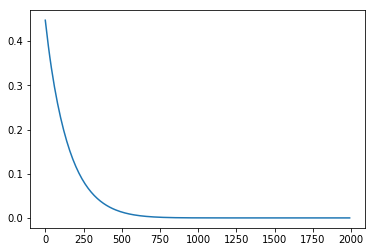

In [408]:
plt.plot(np.arange(history.shape[0])*record_every, history)

----------------

## Stochastic Optimisation with PyTorch
$$ 
\begin{aligned}
KL(p_2||p_1) &= - \int p_2(z) \log \frac{p_1(z)}{p_2(z)} d z \\
&= - \int p_2(z) \log p_1(z) d z + \int p_2(z) \log p_2(z) d z\\
&\approx -\left[ - \frac{1}{2}\log|2\pi\Sigma_1| - \frac{1}{2L}\sum_{i=1}^L (\mathbf{z}_i - \mu_1)^T \Sigma_1^{-1}(\mathbf{z}_i - \mu_1)\right] + \left[ -\frac{1}{2}\log|2\pi e \Sigma_2 | \right] \\
&= \frac{1}{2} \left[ \log|\Sigma_1| - (\log|\Sigma_2| + d) +\frac{1}{L}\text{Tr}\left(\Sigma_1^{-1} Z^T Z)\right)\right]
\end{aligned}
$$

for $z_i \sim \mathcal{N}(\mu_2, \Sigma_2)$ and for the sake of convenience we define the matrix: 

$$Z = \begin{bmatrix} -- & \mathbf{z}_1 - \mu_1 & -- \\ -- & \vdots & -- \\ -- & \mathbf{z}_L - \mu_1 & -- \end{bmatrix}$$

Finally, in order to reduce the variance on the approximation we utilise the 'reparameterisation trick' for which we already have the Cholseky factors:

$$\mathbf{z}_i = \mu_2 + L_2 \boldsymbol{\epsilon}_i$$

for $\boldsymbol{\epsilon}_i \sim \mathcal{N}(0,I)$. (Check that $\mathbb{E} z = \mu_2$ and $\mathbb{E} (z-\mu)(z-\mu)^T = L_2 \mathbb{E}[ zz^T ]L_2^T = L_2 L_2^T = \Sigma_2$ as required.)

In [452]:
mu = Variable(torch.zeros(d), requires_grad=True)
L = Variable(torch.eye(d), requires_grad=True)

In [420]:
def torch_so_kl_gaussian_dbl_solve(mu1, L1, mu2, L2, epsilon):
    d = mu2.size(0)
    ld2 = logdet_using_chol(L2)
    
    ld1 = logdet_using_chol(L1)
    Z = L2 @ epsilon + (mu2.squeeze() - mu1.squeeze())[:,None]
    X = Z @ Z.t() / Z.shape[1]   # = EZZ
    X1 = torch.gesv(X, L1)[0]
    X2 = torch.gesv(X1, L1.t())[0]
    out = ld1 - ld2 - d + torch.trace(X2)
    return out / 2

#### Make sure this is doing the right thing...

In [473]:
def test_approx_kl(n_smp, mu_target_torch, L_target_torch, mu, L):
    epsilon = Variable(torch.randn(d, n_smp), requires_grad=False)
    kl_stoch = torch_so_kl_gaussian_dbl_solve(mu_target_torch, L_target_torch, mu, L, epsilon)
    kl_exact = torch_kl_gaussian_dbl_solve(mu_target_torch, L_target_torch, mu, L).data.numpy()[0]
    kl_stoch = kl_stoch.data.numpy()[0]
    return np.array([kl_exact, kl_stoch, (kl_stoch-kl_exact)/kl_exact])

In [467]:
test_approx_kl(1000)

[ 0.4760381   0.45393378 -0.04643394]


In [483]:
def test_kl_approx(n=100, n_reps=100, n_smp=1000, diff_tol=1e-2):
    out = np.zeros((n, 2))
    for _j in range(n):
        if _j % 10 == 0: print('|', end = '')
        Sigma_1 = stats.wishart.rvs(2, np.eye(d))
        mu_target_1 = stats.multivariate_normal.rvs(mean=np.zeros(d), cov=np.eye(d))
        mu_target_1_torch, L_target_1_torch = convert_suff_stats_torch(mu_target_1, Sigma_1)
        Sigma_2 = stats.wishart.rvs(2, np.eye(d))
        mu_target_2 = stats.multivariate_normal.rvs(mean=np.zeros(d), cov=np.eye(d))
        mu_target_2_torch, L_target_2_torch = convert_suff_stats_torch(mu_target_2, Sigma_2)
        
        results = np.zeros(n_reps)
        for _i in range(n_reps):
            res = test_approx_kl(n_smp, mu_target_1_torch, L_target_1_torch, 
                                           mu_target_2_torch, L_target_2_torch)
            delta = res[2]
            results[_i] = delta
#             if abs(delta) > 20:
#                 warning
        
        out[_j,0] = np.mean(results)
        out[_j,1] = np.std(results)
    
    return out

In [486]:
tmp = test_kl_approx(n_smp=10000)

||||||||||

In [478]:
tmp = _

In [549]:
importlib.reload(axu.plot)

<module 'pyalexutil.plot' from '/Users/abird/python/PycharmProjects/pyalexutil/plot.py'>

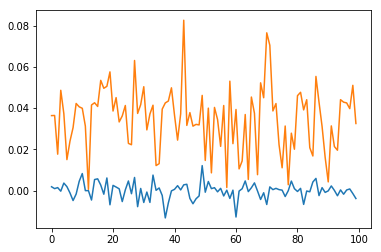

In [485]:
plt.plot(tmp)

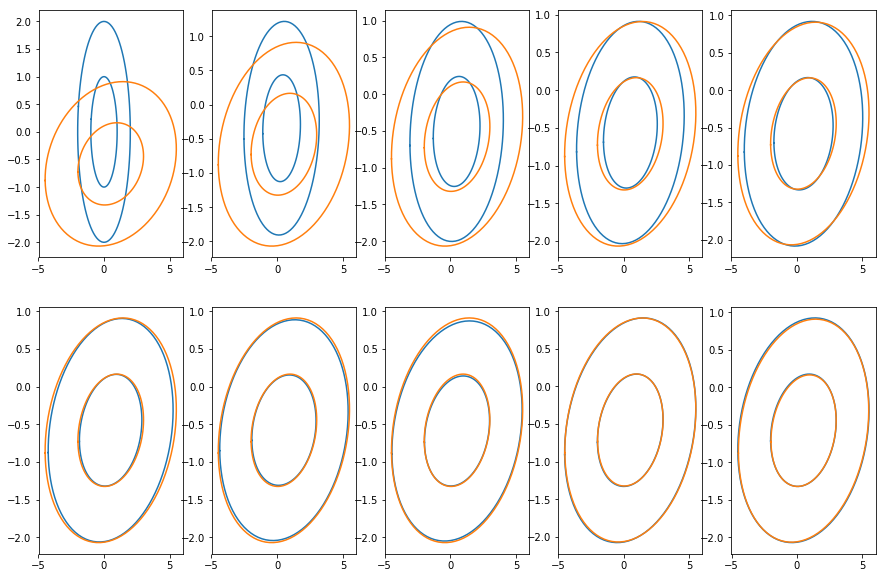

In [581]:
# Target moments are generated above, but we sitll need initialisation:
do_plot = True
plot_every = 1000
    
mu = Variable(torch.zeros(d), requires_grad=True)
L = Variable(torch.eye(d), requires_grad=True)
not_tril = not_tril_mask(d)
record_every = 10

optimizer = optim.Adam([mu, L], lr=0.5e-3)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=np.arange(10)*1e3, gamma=0.99)

epochs = 10000
n_smp = 10
history = np.ones(int(np.ceil(epochs/record_every)))*np.nan
if do_plot:
    f = plt.figure(figsize=(15,10))
    spltdims = axu.plot.subplot_gridsize(epochs/plot_every)

for i in range(epochs):
    epsilon = Variable(torch.randn(d, n_smp), requires_grad=False)
    optimizer.zero_grad()
    loss = torch_so_kl_gaussian_dbl_solve(mu_target_torch, L_target_torch, mu, L, epsilon)
    loss.backward()
    L.grad[not_tril] = 0
    optimizer.step()
    if i % record_every == record_every - 1:
        history[i // record_every] = loss.data.numpy()
    scheduler.step()
    if do_plot and i % plot_every == 0:
        ax = f.add_subplot(*spltdims, (i // plot_every) + 1)
        plot_2d_gaussian_comparison(mu_target_torch, L_target_torch, mu, L, ax)

In [572]:
def plot_2d_gaussian_comparison(mu_target_torch, L_target_torch, mu, L, ax):
    [ax.plot(*axu.plot.gaussian_2D_level_curve(mu.data.numpy().squeeze(), 
                                                (L @ L.t()).data.numpy(), alpha=alpha, plot=False).T, 
              color=mpl.cm.tab10(0)) for alpha in [1,2]];

    [ax.plot(*axu.plot.gaussian_2D_level_curve(mu_target_torch.data.numpy().squeeze(), 
                                                (L_target_torch @ L_target_torch.t()).data.numpy(), alpha=alpha, plot=False).T, 
              color=mpl.cm.tab10(1)) for alpha in [1,2]];

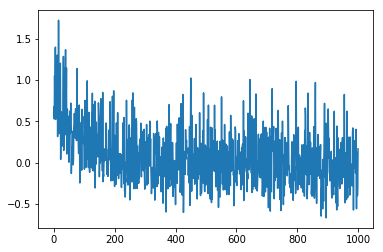

In [574]:
plt.plot(history)